In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Loading (remote) E-OBS observations and summer days (SU) calculation

Git repo: https://github.com/rmsryu/spark-climate-data.git
Data set: https://www.ecad.eu/download/ensembles/download.php

E-OBS data is loaded from the remote OpenDAP repository at KNMI. Please, note that when new versions become available the link is no longer valid since the URL is updated with the version number. Therefore, if the code below doesn't work please check the current E-OBS version and update the URL (https://www.ecad.eu/download/ensembles/download.php). 

# Study of daily precipitation from Station Aalsmeer Netherlands
Data source: https://climexp.knmi.nl/data/rrrr458.dat
Data provide by: Royal Netherlands Meteorological Institute (KNMI)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql.types import *
from pyspark.sql.functions import *



In [131]:
data_files = 'hdfs://hadoop-vm.internal.cloudapp.net:9000/precipitation/rrrr458'
# Obtain dataset
data = spark.read.parquet(data_files)
data = data.withColumn("precipitation", col("precipitation").cast("float"))
data.createOrReplaceTempView("climate")
data.cache()



DataFrame[date: date, precipitation: float]

In [132]:
spark.sql("SELECT \
              count(precipitation) count,\
              mean(precipitation) mean, \
              stddev(precipitation) stddev, \
              min(precipitation) min, \
              percentile(precipitation,0.25) 25pct, \
              percentile(precipitation,0.50) 50pct, \
              percentile(precipitation,0.75) 75pct, \
              max(precipitation) max \
            FROM climate").show()

# same as data.summary().show()

+-----+------------------+-----------------+---+-----+-------------------+------------------+----+
|count|              mean|           stddev|min|25pct|              50pct|             75pct| max|
+-----+------------------+-----------------+---+-----+-------------------+------------------+----+
|35088|2.2715857275430413|4.495996107387759|0.0|  0.0|0.10000000149011612|2.5999999046325684|57.4|
+-----+------------------+-----------------+---+-----+-------------------+------------------+----+



In [133]:
# take 20 % for visualize
data = data[data.precipitation > 0]

In [134]:
data.dtypes

[('date', 'date'), ('precipitation', 'float')]

{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-29T19:27:34.451+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-29T19:27:34.452+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-29T19:27:34.502+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}


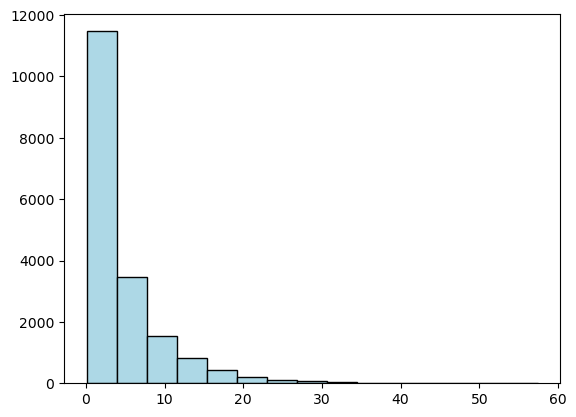

In [138]:
values = data.to_pandas_on_spark().precipitation.tolist()
plt.hist(values, bins=15, color='lightblue', ec = 'black')
fig.set_size_inches(16, 10)